In [8]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split  # Import train_test_split

# ✅ Move GPU settings to the very top before any TF operations
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Load Dataset
data = pd.read_csv("all_stocks_5yr.csv")  # Change to your dataset
close_prices = data['Close'].values.reshape(-1, 1)  # Assuming "Close" price column

# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Function to Create Time Series Dataset
def create_dataset(data, time_steps=90):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

In [9]:
# # Split Data
# train_size = int(len(scaled_data) * 0.8)
# train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# # Create Train/Test Sets
# time_steps = 90  # Increased from 60 to 90 for better trend learning
# x_train, y_train = create_dataset(train_data, time_steps)
# x_test, y_test = create_dataset(test_data, time_steps)

# # Reshape Input for LSTM (Samples, Time Steps, Features)
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


# ✅ Split Data (Train: 80%, Test: 20%)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# ✅ Create Train/Test Sets
time_steps = 90  # Using 90 time steps for better trend learning
x_train, y_train = create_dataset(train_data, time_steps)
x_test, y_test = create_dataset(test_data, time_steps)

# 🔹 Split Training Data into Train (80%) and Validation (20%)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# ✅ Reshape Input for LSTM (Samples, Time Steps, Features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))  # Add this!
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [10]:
# Check for NaN or infinite values
print(np.isnan(x_train).sum(), np.isinf(x_train).sum())
print(np.isnan(y_train).sum(), np.isinf(y_train).sum())
print(np.isnan(x_val).sum(), np.isinf(x_val).sum())  # Should be 0
print(np.isnan(y_val).sum(), np.isinf(y_val).sum())  # Should be 0

# Remove or fill missing values
x_train = np.nan_to_num(x_train)  # Replace NaNs with 0
y_train = np.nan_to_num(y_train)
x_val = np.nan_to_num(x_val)
y_val = np.nan_to_num(y_val)



0 0
0 0
0 0
0 0


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))  # Scale between 0 and 1
x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_val = scaler.transform(x_val.reshape(-1, 1)).reshape(x_val.shape)
x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(x_test.shape)


In [ ]:
# # Build LSTM Model
# model = keras.models.Sequential([
#     keras.layers.LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)),
#     keras.layers.LSTM(units=50, return_sequences=False),
#     keras.layers.Dense(25, activation='relu'),
#     keras.layers.Dropout(0.3),  # Prevent overfitting
#     keras.layers.Dense(1)
# ])

# model.compile(optimizer='adam', loss='mse')

In [19]:
# Define LSTM Model
model = keras.models.Sequential([
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)),
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dropout(0.3),  # Prevent overfitting
    keras.layers.Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("CLOSE_best_model.h5", save_best_only=True, monitor='val_loss', mode='min')

# Train Model
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val), callbacks=[early_stop, checkpoint])

# Save the Final Model
model.save("CLOSE_final_lstm_model.h5")

# Predict on Test Data
predictions = model.predict(x_test)

# Save Predictions (Optional)
np.save("predictions.npy", predictions)


Epoch 1/30
3095/3095 [==============================] - 57s 18ms/step - loss: 1.8898e-04 - val_loss: 3.2175e-05
Epoch 2/30
3095/3095 [==============================] - 59s 19ms/step - loss: 1.6054e-04 - val_loss: 2.3233e-05
Epoch 3/30
3095/3095 [==============================] - 55s 18ms/step - loss: 1.5605e-04 - val_loss: 2.5793e-05
Epoch 4/30
3095/3095 [==============================] - 55s 18ms/step - loss: 1.5121e-04 - val_loss: 3.0042e-05
Epoch 5/30
3095/3095 [==============================] - 59s 19ms/step - loss: 1.5521e-04 - val_loss: 1.7982e-05
Epoch 6/30
3095/3095 [==============================] - 55s 18ms/step - loss: 1.4840e-04 - val_loss: 5.5857e-05
Epoch 7/30
3095/3095 [==============================] - 56s 18ms/step - loss: 1.4550e-04 - val_loss: 3.5255e-05
Epoch 8/30
3095/3095 [==============================] - 56s 18ms/step - loss: 1.5052e-04 - val_loss: 6.8565e-05
Epoch 9/30
3095/3095 [==============================] - 57s 18ms/step - loss: 1.5531e-04 - val_loss: 4.0

In [20]:
# Predict & Inverse Transform
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
r2 = r2_score(y_test_actual, predictions)
print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.4f}')  # Closer to 1 is better

3867/3867 [==============================] - 27s 7ms/step
RMSE: 0.00
R² Score: 0.9928


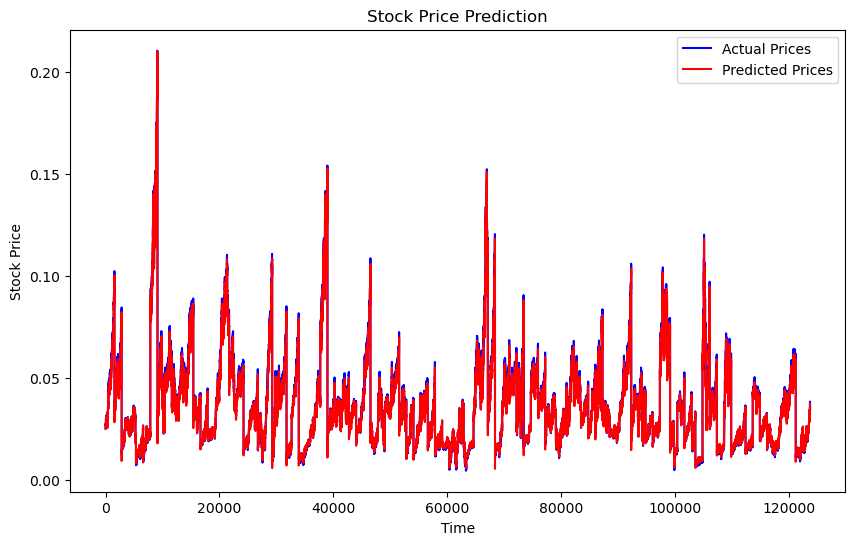

In [21]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(predictions, label="Predicted Prices", color="red")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load Data
data = pd.read_csv('all_stocks_5yr.csv')  # Replace with your file
prices = data['Open'].values.reshape(-1, 1)

# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create Sequences
def create_sequences(data, time_steps=60):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        Y.append(data[i + time_steps])
    return np.array(X), np.array(Y)

time_steps = 60
X, Y = create_sequences(scaled_prices, time_steps)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

# Further Split for Validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=False)

# Define Model
model = Sequential([
    LSTM(units=40, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.3),
    LSTM(units=40, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])




In [20]:
def nan_percentage(arr, name):
    total = arr.size
    nan_count = np.isnan(arr).sum()
    print(f"NaN in {name}: {nan_count} ({(nan_count/total) * 100:.2f}%)")

nan_percentage(x_train, "x_train")
nan_percentage(y_train, "y_train")
nan_percentage(x_val, "x_val")
nan_percentage(y_val, "y_val")
nan_percentage(x_test, "x_test")
nan_percentage(y_test, "y_test")


NaN in x_train: 300 (0.00%)
NaN in y_train: 5 (0.00%)
NaN in x_val: 180 (0.00%)
NaN in y_val: 3 (0.00%)
NaN in x_test: 180 (0.00%)
NaN in y_test: 3 (0.00%)


In [21]:
x_train = np.nan_to_num(x_train, nan=np.nanmean(x_train))  # Replace NaNs with mean
y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train))

x_val = np.nan_to_num(x_val, nan=np.nanmean(x_val))
y_val = np.nan_to_num(y_val, nan=np.nanmean(y_val))

x_test = np.nan_to_num(x_test, nan=np.nanmean(x_test))
y_test = np.nan_to_num(y_test, nan=np.nanmean(y_test))


In [22]:
print(f"NaN in x_train: {np.isnan(x_train).sum()}")
print(f"NaN in y_train: {np.isnan(y_train).sum()}")
print(f"NaN in x_val: {np.isnan(x_val).sum()}")
print(f"NaN in y_val: {np.isnan(y_val).sum()}")
print(f"NaN in x_test: {np.isnan(x_test).sum()}")
print(f"NaN in y_test: {np.isnan(y_test).sum()}")


NaN in x_train: 0
NaN in y_train: 0
NaN in x_val: 0
NaN in y_val: 0
NaN in x_test: 0
NaN in y_test: 0


In [23]:
x_train.size

23768820

In [ ]:
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('open.h5', save_best_only=True, monitor='val_loss')

# Train Model
history = model.fit(
    x_train, y_train, 
    epochs=50, 
    batch_size=32,  # Reduced batch size to improve generalization
    validation_data=(x_val, y_val), 
    callbacks=[early_stop, checkpoint]
)

# Evaluate on Test Set
test_loss = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)  # Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Save Final Model
model.save('lstm_stock_forecast.h5')

In [26]:
import matplotlib.pyplot as plt
import numpy as np

In [30]:
import numpy as np

# Predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate RMSE
train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")


3869/3869 [==============================] - 18s 5ms/step
Train RMSE: 0.0033, Test RMSE: 0.0021


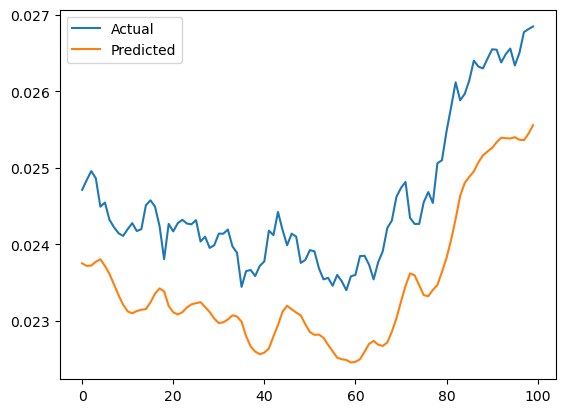

In [31]:
import matplotlib.pyplot as plt

plt.plot(y_test[:100], label="Actual")
plt.plot(y_test_pred[:100], label="Predicted")
plt.legend()
plt.show()
